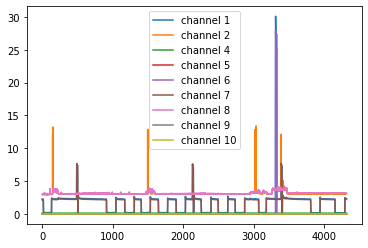

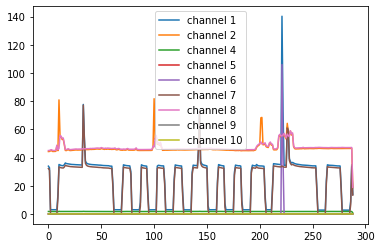

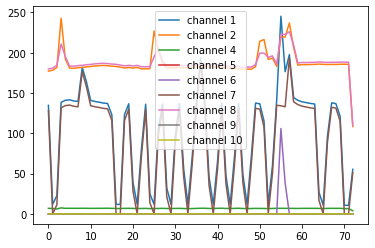

In [1]:
'''
reply from the developer at emporia 

	I think the problem with the y-axis scale on your minutes graph is due to the API returning the kWhs (energy) consumed in that minute.  
	To convert that to watts (power) like the App displays, you need to multiply by 60. 
 
	As for the channels, a Vue1 has 11 CT sensors; the first 3 are the Mains which the app sums together.  
	The next 8 are the individual ones.  
	So when the API return channel 8 it is talking about the circuit that the app displays as #5. 
	So you have to subtract 3.  
	Sorry about the awkwardness there.
'''
from get_data import get_data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


serial_number = 'A2107A04B4B8F009A6CEC4'

l = get_data(serial_number, 3)

mint = l[0]
fivmin = l[1]
hour = l[2]
#min fivmin and hour are all data frames to show what the data looks like adn the graphs show how it will be shown 
# to convert the dataframes to anything that makes it easiest use these commands 
# min = min.to_dict() # to a dictionary 
# min = min.values.tolist() # to a list of lists 
# the list one can look a bit messy that is why i have left it like this so it is easy to see

#print(min)
#print('--------------------')
#print(fivmin)
#print('--------------------')
#print(hour)

mint.plot.line()
fivmin.plot.line()
hour.plot.line()
plt.show()

In [2]:
# this will be a subclass of the main class when it is finished 
class Channel():
    def __init__(self):
        self.items = []
        self.data = None
    def get_scedual(self):
        # not sure how to do this yet but will figure it out 
        return 

In [3]:
# this will take out the 3 first channels and get the mains 
def get_channels(data):
    list_of_series = []
    try: 
        data = data.drop(['date','time'], axis = 1)
    except:
        pass
    total = pd.Series(0,index=range(len(data)),dtype='float64')
    cols = data.columns.tolist()

    #total = np.array(len(data))
    for i in cols:
        if i == 'channel 1' or i == 'channel 2' or i == 'channel 3':
            t = data[i]
            total = total.add(t)
        else:
            channy = Channel()
            channy.data = data[i]
            list_of_series.append(channy)

    t = Channel()
    t.data = total

    return [t, list_of_series]


In [4]:
# helper function to convert utc to loacal time. 
# takes in a list of date and time 
# time returned is in UTC (unix time) every second since jan 1970 
from datetime import datetime 
from dateutil import tz
def UTC_MTN(date_time):
    from_zone = tz.tzutc()
    to_zone = tz.tzlocal()
    r = []
    
    for i in date_time:
        utc = datetime.strptime(i, '%Y-%m-%d %H:%M:%S')
        utc = utc.replace(tzinfo=from_zone)
        central = utc.astimezone(to_zone)

        r.append(central)

    

    dater = pd.DataFrame(columns = ['datetime'])

    dater['datetime'] = r
    

    return dater


In [5]:
# need a function that cleans up all the data
# this data is right from get_data call
def clean_data(data):
    c = get_channels(data)
    c_mains = c[0]
    channels = c[1]
    t = data['time']
    d = data['date']

    date_time = []
    
    for i in range(len(t)): 
        date_time.append(d[i] + ' ' + t[i])
    
    local_time = UTC_MTN(date_time)
    

    t = []
    d = []
    m = []
    y = []
    mi = []
    for i in local_time['datetime']:
        t.append(i.hour)
        d.append(i.day)
        m.append(i.month)
        y.append(i.year)
        mi.append(i.minute)

    
    t = pd.Series(t)
    d = pd.Series(d)
    m = pd.Series(m)
    y = pd.Series(y)
    mi = pd.Series(mi)
    inp = [y,m,d,t,mi]
    mains = inp.copy()
    mains.append(c_mains.data)

    for i in channels:
        inp.append(i.data)

    mains_df = pd.concat(mains,axis=1)
    mains_df = mains_df.rename(columns={0:'year'})
    mains_df = mains_df.rename(columns={1:'month'})
    mains_df = mains_df.rename(columns={2:'day'})
    mains_df = mains_df.rename(columns={3:'hour'})
    mains_df = mains_df.rename(columns={4:'minute'})
    mains_df = mains_df.rename(columns={5:'mains'})

    chan = pd.concat(inp,axis=1)
    chan = chan.rename(columns={0:'year'})
    chan = chan.rename(columns={1:'month'})
    chan = chan.rename(columns={2:'day'})
    chan = chan.rename(columns={3:'hour'})
    chan = chan.rename(columns={4:'minute'})

    
    chan = chan.apply(pd.to_numeric)
    

    

    return [mains_df, chan]
    


In [6]:
mains, chan = clean_data(hour)
print(mains)
print(chan)

    year  month  day  hour  minute       mains
0   2021      6   26     9       0  311.855134
1   2021      6   26    10       0  190.115465
2   2021      6   26    11       0  204.336395
3   2021      6   26    12       0  381.317084
4   2021      6   26    13       0  333.424682
..   ...    ...  ...   ...     ...         ...
68  2021      6   29     5       0  322.322484
69  2021      6   29     6       0  307.144521
70  2021      6   29     7       0  196.496090
71  2021      6   29     8       0  196.320822
72  2021      6   29     9       0  163.762585

[73 rows x 6 columns]
    year  month  day  hour  minute  channel 4  channel 5  channel 6  \
0   2021      6   26     9       0   6.938342        0.0   0.001432   
1   2021      6   26    10       0   6.711964        0.0   0.001444   
2   2021      6   26    11       0   6.133473        0.0   0.001409   
3   2021      6   26    12       0   7.496235        0.0   0.001401   
4   2021      6   26    13       0   6.949159        0.0  

In [7]:
# need to get a average hourly usage chart per channel. hasattr
# this will take in a clean data set that has been ran through clean_data and return the average channel usage over the past x amount of days. 

def ave_channel_usage(channels_hours):
    gpchan = channels_hours.groupby('hour', as_index = False).mean()
    stdchan = channels_hours.groupby('hour', as_index = False).std()

    try:
        gpchan = gpchan.drop(['year','month','day','minute'], axis=1)
        stdchan = stdchan.drop(['year','month','day','minute'], axis=1)
    except:
        pass


    return gpchan, stdchan

averchan, stdchan = ave_channel_usage(chan)

print(averchan)
print(stdchan['channel 4'][0])


    hour  channel 4  channel 5  channel 6   channel 7   channel 8  channel 9  \
0      0   6.854993   0.000000   0.000000   82.301716  186.460667   0.000481   
1      1   6.855195   0.000500   0.001451   23.928260  186.327198   0.000502   
2      2   6.804315   0.000000   0.001017   43.636235  185.775568   0.000000   
3      3   6.843318   0.000000   0.001441   80.623884  185.157442   0.000000   
4      4   6.885320   0.000000   0.002483   87.443544  185.307346   0.000000   
5      5   6.864201   0.000000   0.000483   73.395105  184.861095   0.000995   
6      6   6.891254   0.000000   0.002409   81.871846  185.133741   0.000000   
7      7   6.712537   0.000000   0.001034   36.814839  184.391338   0.000508   
8      8   6.694512   0.000000   0.000469   43.201132  184.353492   0.000523   
9      9   6.048910   0.000000   0.001485   63.736055  163.698748   0.000000   
10    10   6.735532   0.000000   0.001998   43.680599  187.031134   0.000000   
11    11   6.569424   0.000000   0.00047

In [23]:
# need to get last 7 days usage by 24 hours 
# takes in all channels and then returns 11 data frames that are 24 rows by 7 days 
def on_off_usage(channels):
    #print(channels)

    dayz = channels.groupby('day', as_index= False).count()
    #print(d)

    all_days = dayz['day'].values

    t = channels.groupby(['day','hour'], as_index = False).last()
   

    channels = t.drop(columns = ['year','month','minute'])
    
    
    # get the average and the standard diviation of the channels 
    averchan, stdchan = ave_channel_usage(channels)


    # init the data frame the on and off structure will be going  into 
    # make the thing a dict 
    dd = {}
    for i in all_days:
        dd['day: '+ str(i)] = np.zeros(24)

    output_df = pd.DataFrame(dd)

    # now we loop through all the channels usage 
    # if the usage is greater then the mean + (0.5*std) of that time frame. we then assume the circuit is on.

    # need a channel list 
    cols = channels.columns.tolist()
    # drop hours and 
    if (cols[0] == 'day') & (cols[1] == 'hour'):
        cols = cols[2:]


    row_dict = {}

    for c in cols:
        row_dict[c] = output_df.copy()

    for d in all_days: 
        for h in range(24): # hours in a day does not change  
            for c in cols: 
                row = channels[(channels['day'] == int(d)) & (channels['hour'] == int(h))]
                if row.empty:
                    
                    continue

                row = row.reset_index()
                usage = row[c][0]
                std = stdchan[c][h]
                ave = averchan[c][h]
                if usage > (ave + (0.5*std)):
                    # it is on 
                    row_dict[c].at[h, 'day: ' + str(d)] = 1
                    
                else:
                    # it is off
                    pass
    
    return row_dict

ret = on_off_usage(chan)
print(ret)

{'channel 4':     day: 26  day: 27  day: 28  day: 29
0       0.0      0.0      0.0      1.0
1       0.0      0.0      1.0      0.0
2       0.0      0.0      1.0      0.0
3       0.0      1.0      0.0      0.0
4       0.0      1.0      0.0      1.0
5       0.0      0.0      0.0      1.0
6       0.0      0.0      1.0      0.0
7       0.0      1.0      0.0      0.0
8       0.0      1.0      0.0      0.0
9       1.0      0.0      0.0      0.0
10      0.0      0.0      1.0      0.0
11      0.0      1.0      1.0      0.0
12      1.0      0.0      0.0      0.0
13      1.0      0.0      0.0      0.0
14      1.0      0.0      0.0      0.0
15      1.0      0.0      0.0      0.0
16      0.0      0.0      1.0      0.0
17      1.0      0.0      0.0      0.0
18      1.0      0.0      0.0      0.0
19      1.0      0.0      0.0      0.0
20      1.0      0.0      0.0      0.0
21      0.0      1.0      0.0      0.0
22      0.0      1.0      0.0      0.0
23      1.0      0.0      0.0      0.0, 'channel 5